# Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression 
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import pickle


ModuleNotFoundError: No module named 'seaborn'

# Load and describe data


In [2]:
df=pd.read_csv('mobile_prices_regression.csv')
df

,Phone Name,Rating ?/5,Number of Ratings,RAM,ROM/Storage,Back/Rare Camera,Front Camera,Battery,Processor,Price in INR,Date of Scraping
0,"POCO C50 (Royal Blue, 32 GB)",4.2,"33,561",2 GB RAM,32 GB ROM,8MP Dual Camera,5MP Front Camera,5000 mAh,"Mediatek Helio A22 Processor, Upto 2.0 GHz Pro...","₹5,649",2023-06-17
1,"POCO M4 5G (Cool Blue, 64 GB)",4.2,"77,128",4 GB RAM,64 GB ROM,50MP + 2MP,8MP Front Camera,5000 mAh,Mediatek Dimensity 700 Processor,"₹11,999",2023-06-17
2,"POCO C51 (Royal Blue, 64 GB)",4.3,"15,175",4 GB RAM,64 GB ROM,8MP Dual Rear Camera,5MP Front Camera,5000 mAh,Helio G36 Processor,"₹6,999",2023-06-17
3,"POCO C55 (Cool Blue, 64 GB)",4.2,"22,621",4 GB RAM,64 GB ROM,50MP Dual Rear Camera,5MP Front Camera,5000 mAh,Mediatek Helio G85 Processor,"₹7,749",2023-06-17
4,"POCO C51 (Power Black, 64 GB)",4.3,"15,175",4 GB RAM,64 GB ROM,8MP Dual Rear Camera,5MP Front Camera,5000 mAh,Helio G36 Processor,"₹6,999",2023-06-17
...,...,...,...,...,...,...,...,...,...,...,...
1831,"Infinix Note 7 (Forest Green, 64 GB)",4.3,"25,582",4 GB RAM,64 GB ROM,48MP + 2MP + 2MP + AI Lens Camera,16MP Front Camera,5000 mAh,MediaTek Helio G70 Processor,"₹14,999",2023-06-17
1832,"Infinix Note 7 (Bolivia Blue, 64 GB)",4.3,"25,582",4 GB RAM,64 GB ROM,48MP + 2MP + 2MP + AI Lens Camera,16MP Front Camera,5000 mAh,MediaTek Helio G70 Processor,"₹14,999",2023-06-17
1833,"Infinix Note 7 (Aether Black, 64 GB)",4.3,"25,582",4 GB RAM,64 GB ROM,48MP + 2MP + 2MP + AI Lens Camera,16MP Front Camera,5000 mAh,MediaTek Helio G70 Processor,"₹14,999",2023-06-17
1834,"Infinix Zero 8i (Silver Diamond, 128 GB)",4.2,"7,117",8 GB RAM,128 GB ROM,48MP + 8MP + 2MP + AI Lens Camera,16MP + 8MP Dual Front Camera,4500 mAh,MediaTek Helio G90T Processor,"₹18,999",2023-06-17


In [4]:
df.shape

(1836, 11)

In [5]:
df.dtypes

Phone Name            object
Rating ?/5           float64
Number of Ratings     object
RAM                   object
ROM/Storage           object
Back/Rare Camera      object
Front Camera          object
Battery               object
Processor             object
Price in INR          object
Date of Scraping      object
dtype: object

In [6]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Rating ?/5,1836.0,4.210512,0.543912,0.0,4.2,4.3,4.4,4.8


In [23]:
df.nunique()

phone_name           1507
rating_5               22
number_of_ratings     717
ram                    46
rom                    27
back_camera           174
front_camera           29
battery               102
processor             332
price_DZD             519
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Phone Name         1836 non-null   object 
 1   Rating ?/5         1836 non-null   float64
 2   Number of Ratings  1836 non-null   object 
 3   RAM                1836 non-null   object 
 4   ROM/Storage        1662 non-null   object 
 5   Back/Rare Camera   1827 non-null   object 
 6   Front Camera       1435 non-null   object 
 7   Battery            1826 non-null   object 
 8   Processor          1781 non-null   object 
 9   Price in INR       1836 non-null   object 
 10  Date of Scraping   1836 non-null   object 
dtypes: float64(1), object(10)
memory usage: 157.9+ KB


# Pre-processing

In [8]:
df.columns=[column.lower().replace(" ","_") for column in df.columns]

# Exploratory Data Analysis (EDA)

 i want to convert our target from INR to DZD :
 
 Given exchange rate from INR to DZD
 
 Function to convert a single price

 Apply the conversion to the entire column


In [9]:
exchange_rate_inr_to_dzd = 1.44  

def convert_to_dzd(price_inr):
    price_numeric = float(price_inr.replace('₹', '').replace(',', ''))
    price_dzd = price_numeric * exchange_rate_inr_to_dzd
    return price_dzd
df['price_DZD'] = df['price_in_inr'].apply(convert_to_dzd)

df.number_of_ratings=df.number_of_ratings.str.replace(",","")
df.battery=df.battery.str.replace("mAh","")

df.front_camera=df.front_camera.str.replace("Front Camera","").str.replace("Dual","").str.replace("MP","").str.replace("20 + 2 ","22").str.replace("32 + 8 ","40").str.replace("16 + 8 ","24").str.replace("32 + 2 ","34").str.replace("16 + 2 ","18").str.replace("44 + 2 ","46").str.replace("8 + 8 ","16").str.replace("50 + 8 ","58").str.replace("8 + 2 ","10").str.replace("13 + 5 ","18") 


In [10]:
del df['date_of_scraping']
del df['price_in_inr']

In [12]:
columns =['phone_name', 'rating_5', 'number_of_ratings', 'ram', 'rom',
       'back_camera', 'front_camera', 'battery', 'processor',
       'price_DZD']
df.columns=columns


In [13]:
df.rom=df.rom.str.replace('ROM','')


As we see there is some missing values but i prefer deling with them after spliting the data to avoid 'data leackage'

In [14]:
df.isna().sum()


phone_name             0
rating_5               0
number_of_ratings      0
ram                    0
rom                  174
back_camera            9
front_camera         401
battery               10
processor             55
price_DZD              0
dtype: int64

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating_5,1836.0,4.210512,0.543912,0.00,4.20,4.30,4.4,4.80
price_DZD,1836.0,34165.997647,35101.562563,1726.56,14398.56,23038.56,40305.6,244798.56


In [15]:
df[df['price_DZD']== 244798.560000]

,phone_name,rating_5,number_of_ratings,ram,rom,back_camera,front_camera,battery,processor,price_DZD
488,"APPLE iPhone 14 Pro (Gold, 1 TB)",4.7,1302,1 TB ROM,NaN,48MP + 12MP + 12MP,12,A16,1 Year Warranty for Phone and 6 Months Warrant...,244798.56
493,"APPLE iPhone 14 Pro (Space Black, 1 TB)",4.7,1302,1 TB ROM,NaN,48MP + 12MP + 12MP,12,A16,1 Year Warranty for Phone and 6 Months Warrant...,244798.56
495,"APPLE iPhone 14 Pro (Silver, 1 TB)",4.7,1302,1 TB ROM,NaN,48MP + 12MP + 12MP,12,A16,1 Year Warranty for Phone and 6 Months Warrant...,244798.56


In [16]:
df[df['rom']== '20 MB ']

,phone_name,rating_5,number_of_ratings,ram,rom,back_camera,front_camera,battery,processor,price_DZD
1413,"Nokia Asha 310 (White, 20 MB)",3.9,286,64 MB RAM,20 MB,2MP Rear Camera,NaN,1110,1 Year for Mobile & 6 Months for Accessories,9070.56


/home/hamza/ML-ZOOMCAMP/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hamza/ML-ZOOMCAMP/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hamza/ML-ZOOMCAMP/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='rating_5', ylabel='count'>

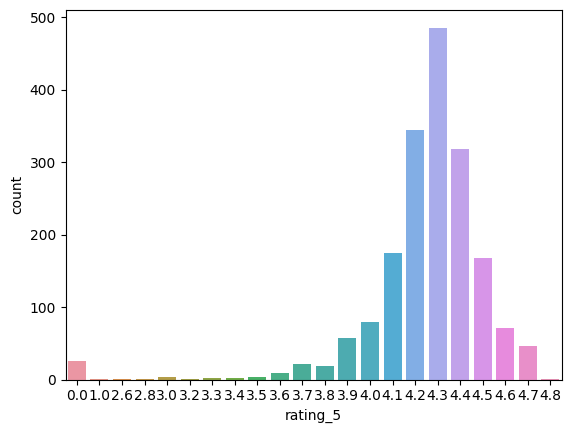

In [34]:
sns.countplot(x='rating_5',data=df,orient="horizan")

Skew: 2.8115650454631766
Kurtosis: 9.555123335849915


/tmp/ipykernel_4214/145414745.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df['price_DZD'],shade=True,color='g')
/home/hamza/ML-ZOOMCAMP/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hamza/ML-ZOOMCAMP/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


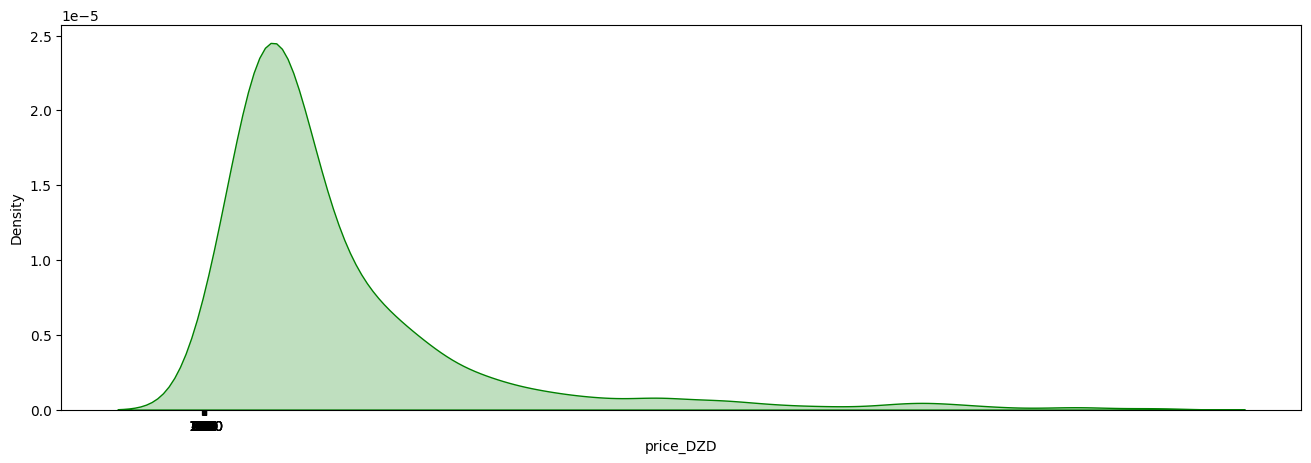

In [334]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df['price_DZD'].skew()))
print("Kurtosis: {}".format(df['price_DZD'].kurtosis()))
ax = sns.kdeplot(df['price_DZD'],shade=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

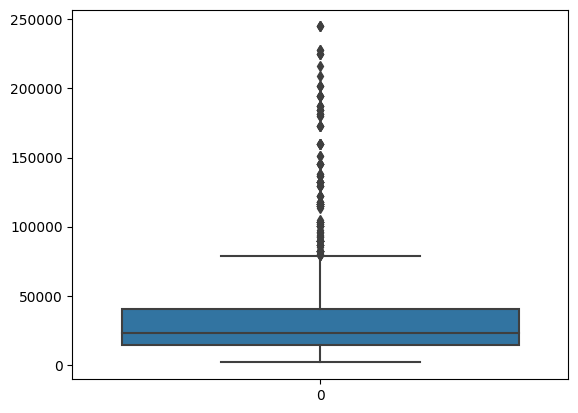

In [335]:

ax = sns.boxplot(df['price_DZD'])


# Modeling

### Split our data to train and test 

In [16]:
train,test=train_test_split(df,random_state=123,test_size=.2)


In [17]:
y_train = train.price_DZD.values
y_test = test.price_DZD.values

x_train = train
x_test = test

del x_train['phone_name']
del x_test['phone_name']


 ## Missing value treatment   
    
    Now we can fill the missing values

In [18]:
x_train.isna().sum()

rating_5               0
number_of_ratings      0
ram                    0
rom                  143
back_camera            7
front_camera         318
battery                8
processor             47
price_DZD              0
dtype: int64

In [19]:
x_train['rom'].fillna(x_train['rom'].mode()[0],inplace=True)
x_train['back_camera'].fillna(x_train['back_camera'].mode()[0],inplace=True)
x_train['front_camera'].fillna(x_train['front_camera'].mode()[0],inplace=True)
x_train['battery'].fillna(x_train['battery'].mode()[0],inplace=True)
x_train['processor'].fillna(x_train['processor'].mode()[0],inplace=True)


In [20]:
x_train.isna().sum()

rating_5             0
number_of_ratings    0
ram                  0
rom                  0
back_camera          0
front_camera         0
battery              0
processor            0
price_DZD            0
dtype: int64

In [21]:
x_test.isna().sum()

rating_5              0
number_of_ratings     0
ram                   0
rom                  31
back_camera           2
front_camera         83
battery               2
processor             8
price_DZD             0
dtype: int64

In [22]:
x_test['rom'].fillna(x_test['rom'].mode()[0],inplace=True)
x_test['back_camera'].fillna(x_test['back_camera'].mode()[0],inplace=True)
x_test['front_camera'].fillna(x_test['front_camera'].mode()[0],inplace=True)
x_test['battery'].fillna(x_test['battery'].mode()[0],inplace=True)
x_test['processor'].fillna(x_test['processor'].mode()[0],inplace=True)


In [24]:
x_test.isna().sum()

rating_5             0
number_of_ratings    0
ram                  0
rom                  0
back_camera          0
front_camera         0
battery              0
processor            0
price_DZD            0
dtype: int64

### Preparing the data for modelling

In [25]:
x_train = x_train.to_dict(orient='records')

dict_v= DictVectorizer(sparse=False)
x_train= dict_v.fit_transform(x_train)

x_test = x_test.to_dict(orient='records')

x_test=dict_v.transform(x_test)

## Xgboost for regression

In [26]:
XGBR_model=XGBRegressor()
XGBR_model.fit(x_train,y_train)
XGBR_predict=XGBR_model.predict(x_test)
mean_absolute_error(y_test,XGBR_predict)

190.81928787894884

## Linear Regression

In [27]:
LR_model=LinearRegression()
LR_model.fit(x_train,y_train)
LR_predict=LR_model.predict(x_test)
mean_absolute_error(y_test,LR_predict)

0.0003017888711937026

## Adaboost

In [28]:
ada_model=AdaBoostRegressor()
ada_model.fit(x_train,y_train)
ada_predict=ada_model.predict(x_test)
mean_absolute_error(y_test,ada_predict)

2495.352724959001

# the best model

In [60]:
LR_model=LinearRegression()
LR_model.fit(x_train,y_train)
LR_predict=LR_model.predict(x_test)
mean_absolute_error(y_test,LR_predict)

0.0003017888711937026

# Saving the model

In [61]:
with open('LRmodel.bin','wb') as model :
    pickle.dump(LR_model,model)

In [62]:
with open('dictv.bin','wb') as dvv :
    pickle.dump(dict_v,dvv)